In [1]:
# Import necessary libraries
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Load the pre-trained ResNet50 model (without top layers)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(227, 227, 3))

# Freeze the convolutional base to retain pre-trained features
base_model.trainable = False


In [2]:
# Build the model
resnetModel = Sequential([
    base_model,
    GlobalAveragePooling2D(),  # Reduce feature maps to a single vector
    Dense(256, activation='relu'),
    Dropout(0.5),  # Helps prevent overfitting
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])

In [3]:
# Compile the model
resnetModel.compile(optimizer=Adam(learning_rate=0.0001),
                    loss='binary_crossentropy',
                    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

# Model summary
resnetModel.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 8, 8, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,112,513 (91.98 MB)

 Trainable params: 524,801 (2.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [5]:
# Save initial weights
resnetModel.save_weights("resnetModelWeights.weights.h5")

# Data augmentation for training
batch_size = 32
train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)

# Load images
train_generator = train_datagen.flow_from_directory('data_8k/train', target_size=(227, 227), batch_size=batch_size, class_mode='binary')
validation_generator = test_datagen.flow_from_directory('data_8k/validation', target_size=(227, 227), batch_size=batch_size, class_mode='binary')
test_generator = test_datagen.flow_from_directory('data_8k/test', target_size=(227, 227), batch_size=batch_size, class_mode='binary')


Found 1845 images belonging to 2 classes.
Found 288 images belonging to 2 classes.
Found 319 images belonging to 2 classes.


In [9]:
# Early stopping callback
es = EarlyStopping(monitor='val_accuracy', patience=8, min_delta=0.001)

# Train the model
import time
start_time = time.time()

resnetModel.fit(train_generator, epochs=10, validation_data=validation_generator, callbacks=[es])


finish_time = time.time()
time_taken = finish_time - start_time
print('\nTraining complete in {:.0f}m {:.0f}s'.format(time_taken // 60, time_taken % 60))

# Evaluate the model
test_loss, accuracy, precision, recall = resnetModel.evaluate(test_generator)
print('Accuracy:', accuracy, '\nPrecision:', precision, '\nRecall:', recall)

Epoch 1/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 150s 3s/step - accuracy: 0.6460 - loss: 0.6377 - precision: 0.6675 - recall: 0.5271 - val_accuracy: 0.7083 - val_loss: 0.6136 - val_precision: 0.7748 - val_recall: 0.5931
Epoch 2/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 136s 2s/step - accuracy: 0.6426 - loss: 0.6397 - precision: 0.6484 - recall: 0.4863 - val_accuracy: 0.7014 - val_loss: 0.6160 - val_precision: 0.8242 - val_recall: 0.5172
Epoch 3/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 149s 3s/step - accuracy: 0.6431 - loss: 0.6379 - precision: 0.6672 - recall: 0.5651 - val_accuracy: 0.7500 - val_loss: 0.6082 - val_precision: 0.7212 - val_recall: 0.8207
Epoch 4/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.6530 - loss: 0.6287 - precision: 0.6530 - recall: 0.5790 - val_accuracy: 0.7049 - val_loss: 0.6080 - val_precision: 0.8191 - val_recall: 0.5310
Epoch 5/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 137s 2s/step - accuracy: 0.6819 - loss: 0.6292 - precision: 0.7017 - recall: 0.5615 - val_accuracy: 0.7465 - val_loss: 0.5975 

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, applications

def ResNet_segmentation(input_shape=(256, 256, 3)):
    # Load ResNet without the top classification layers
    base_model = applications.ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

    # Freeze ResNet layers to use as a feature extractor
    for layer in base_model.layers:
        layer.trainable = False

    # Decoder (Upsampling for Segmentation)
    x = base_model.output
    x = layers.Conv2DTranspose(256, (3, 3), strides=2, activation='relu', padding='same')(x)
    x = layers.Conv2DTranspose(128, (3, 3), strides=2, activation='relu', padding='same')(x)
    x = layers.Conv2DTranspose(64, (3, 3), strides=2, activation='relu', padding='same')(x)
    x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation='relu', padding='same')(x)

    # Final segmentation mask
    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid', padding='same')(x)

    model = models.Model(inputs=base_model.input, outputs=outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Create model
input_shape = (256, 256, 3)
model = ResNet_segmentation(input_shape)


In [ ]:
import numpy as np
import cv2
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split

# Dataset Paths
image_path = r"C:\Users\USER\Desktop\CRACK_DETECTION\crack_detection\Crack_Segmentation_Dataset\images"
mask_path = r"C:\Users\USER\Desktop\CRACK_DETECTION\crack_detection\Crack_Segmentation_Dataset\masks"

image_size = (256, 256)

def load_data(image_path, mask_path):
    images = []
    masks = []
    
    image_files = sorted(os.listdir(image_path))
    mask_files = sorted(os.listdir(mask_path))

    for img_file, mask_file in zip(image_files, mask_files):
        img = load_img(os.path.join(image_path, img_file), target_size=image_size)
        mask = load_img(os.path.join(mask_path, mask_file), target_size=image_size, color_mode="grayscale")

        img = img_to_array(img) / 255.0  # Normalize
        mask = img_to_array(mask) / 255.0  # Normalize

        images.append(img)
        masks.append(mask)

    return np.array(images), np.array(masks)

# Load dataset
X, Y = load_data(image_path, mask_path)

# Train-Test Split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)


In [ ]:
# Train Model
model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=20, batch_size=16)


In [ ]:
import matplotlib.pyplot as plt

# Select a test image
idx = np.random.randint(0, len(X_test))
test_image = X_test[idx]
test_mask = Y_test[idx]

# Predict the mask
predicted_mask = model.predict(np.expand_dims(test_image, axis=0))[0]

# Plot results
fig, ax = plt.subplots(1, 3, figsize=(12, 6))
ax[0].imshow(test_image)
ax[0].set_title("Original Image")

ax[1].imshow(test_mask.squeeze(), cmap='gray')
ax[1].set_title("Ground Truth Mask")

ax[2].imshow(predicted_mask.squeeze(), cmap='gray')
ax[2].set_title("Predicted Mask")

plt.show()


### VISUALISING PREDICTIONS OF ALEXNET MODEL TRAINED ON 8K IMAGES

In [20]:
print(dir())  # List all defined variables


['Adam', 'Dense', 'Dropout', 'EarlyStopping', 'Flatten', 'GlobalAveragePooling2D', 'ImageDataGenerator', 'In', 'Model', 'Out', 'ResNet50', 'Sequential', '_', '_16', '_6', '__', '___', '__builtin__', '__builtins__', '__doc__', '__loader__', '__name__', '__package__', '__session__', '__spec__', '_dh', '_i', '_i1', '_i10', '_i11', '_i12', '_i13', '_i14', '_i15', '_i16', '_i17', '_i18', '_i19', '_i2', '_i20', '_i3', '_i4', '_i5', '_i6', '_i7', '_i8', '_i9', '_ih', '_ii', '_iii', '_oh', 'accuracy', 'base_model', 'batch', 'batch_size', 'es', 'exit', 'finish_time', 'get_ipython', 'np', 'open', 'plt', 'precision', 'quit', 'recall', 'resnetModel', 'start_time', 'test_datagen', 'test_generator', 'test_loss', 'tf', 'time', 'time_taken', 'train_datagen', 'train_generator', 'validation_generator', 'visualization_generator_8K']


In [16]:
[x for x in dir() if 'visual' in x.lower()]
[x for x in dir() if 'generator' in x.lower()]


['ImageDataGenerator',
 'test_generator',
 'train_generator',
 'validation_generator']

In [17]:
batch = next(train_generator)  # Fetch a batch of images
visualization_generator_8K = batch[0]  # Assuming images are in batch[0]


In [19]:
visualization_generator_8K = resnetModel.predict(test_generator)


10/10 ━━━━━━━━━━━━━━━━━━━━ 36s 3s/step


In [21]:
imgarr_8K = visualization_generator_8K[0][0]


In [26]:
random_image_path = "C:/Users/USER/Desktop/CRACK_DETECTION/istockphoto-1080117220-612x612.jpg"

In [27]:
def highlight_cracks(im, model):
    output_image = np.zeros_like(im)
    a = 0
    for i in range(12):
        k = 0
        for j in range(12):
            p = im[a:a+100, k:k+100]
            resizeIm = cv2.resize(p, (227, 227))
            im_arr = np.zeros((1, 227, 227, 3))
            im_arr[0] = resizeIm
            pred = model.predict(im_arr)
            prediction = np.array(pred).round()
            if(prediction == 0):
                color = (255, 26, 26)
            else:
                color = (153, 255, 153)
            b = np.zeros_like(p, dtype=np.uint8)
            b[:] = color
            add_img = cv2.addWeighted(p, 0.83, b, 0.17, 0)
            output_image[a:a+100, k:k+100] = add_img
            k += 100
        a += 100
    return output_image

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

Text(0.5, 1.0, 'Raw Image')

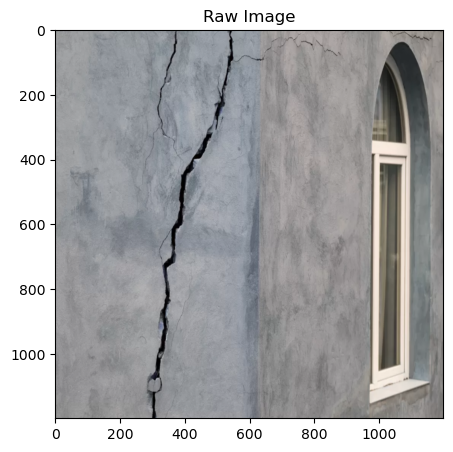

In [29]:
import cv2
import matplotlib.pyplot as plt

im = cv2.imread(random_image_path)
im = cv2.resize(im, (1200, 1200))
crack_highlighted_image = highlight_cracks(im, resnetModel)
fig = plt.figure(figsize=(120, 120))
axisarr = fig.add_subplot(20, 20, 1)
axisarr.imshow(im)
axisarr.set_title('Raw Image')



Text(0.5, 1.0, 'Crack Highlighted Image')

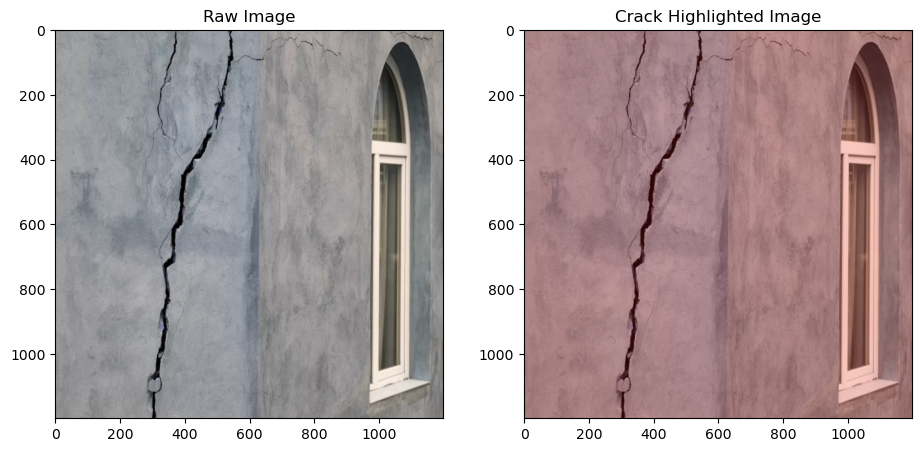

In [30]:
fig = plt.figure(figsize=(120, 120))
axisarr = fig.add_subplot(20, 20, 1)
axisarr.imshow(im)
axisarr.set_title('Raw Image')

axisarr = fig.add_subplot(20, 20, 2)
axisarr.imshow(crack_highlighted_image)
axisarr.set_title('Crack Highlighted Image')

In [35]:
random_image_path2 = "C:/Users/USER/Desktop/CRACK_DETECTION/istockphoto-1080117220-612x612_2.jpg"

In [36]:
def highlight_cracks(im, model):
    output_image = np.zeros_like(im)
    a = 0
    for i in range(12):
        k = 0
        for j in range(12):
            p = im[a:a+100, k:k+100]
            resizeIm = cv2.resize(p, (227, 227))
            im_arr = np.zeros((1, 227, 227, 3))
            im_arr[0] = resizeIm
            pred = model.predict(im_arr)
            prediction = np.array(pred).round()
            if(prediction == 0):
                color = (255, 26, 26)
            else:
                color = (153, 255, 153)
            b = np.zeros_like(p, dtype=np.uint8)
            b[:] = color
            add_img = cv2.addWeighted(p, 0.83, b, 0.17, 0)
            output_image[a:a+100, k:k+100] = add_img
            k += 100
        a += 100
    return output_image

In [39]:
import cv2
import matplotlib.pyplot as plt

im = cv2.imread(random_image_path2)
im = cv2.resize(im, (1200, 1200))
crack_highlighted_image = highlight_cracks(im, resnetModel)



1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

Text(0.5, 1.0, 'Crack Highlighted Image')

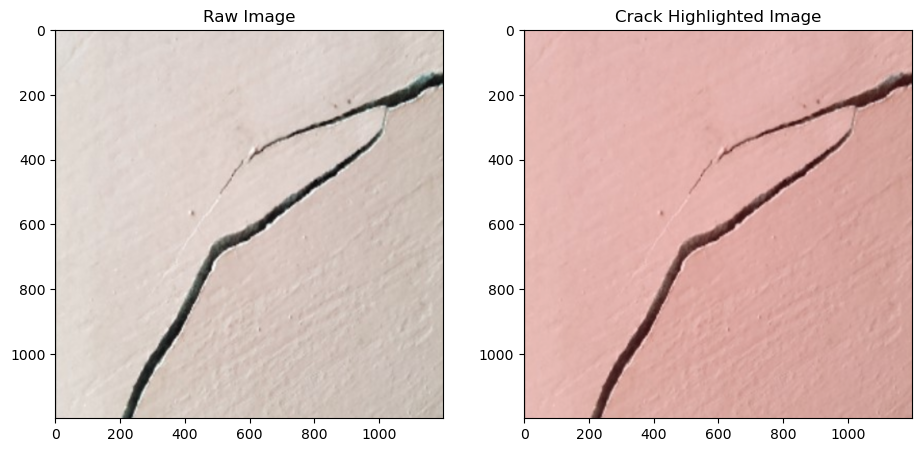

In [40]:
fig = plt.figure(figsize=(120, 120))
axisarr = fig.add_subplot(20, 20, 1)
axisarr.imshow(im)
axisarr.set_title('Raw Image')

axisarr = fig.add_subplot(20, 20, 2)
axisarr.imshow(crack_highlighted_image)
axisarr.set_title('Crack Highlighted Image')

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

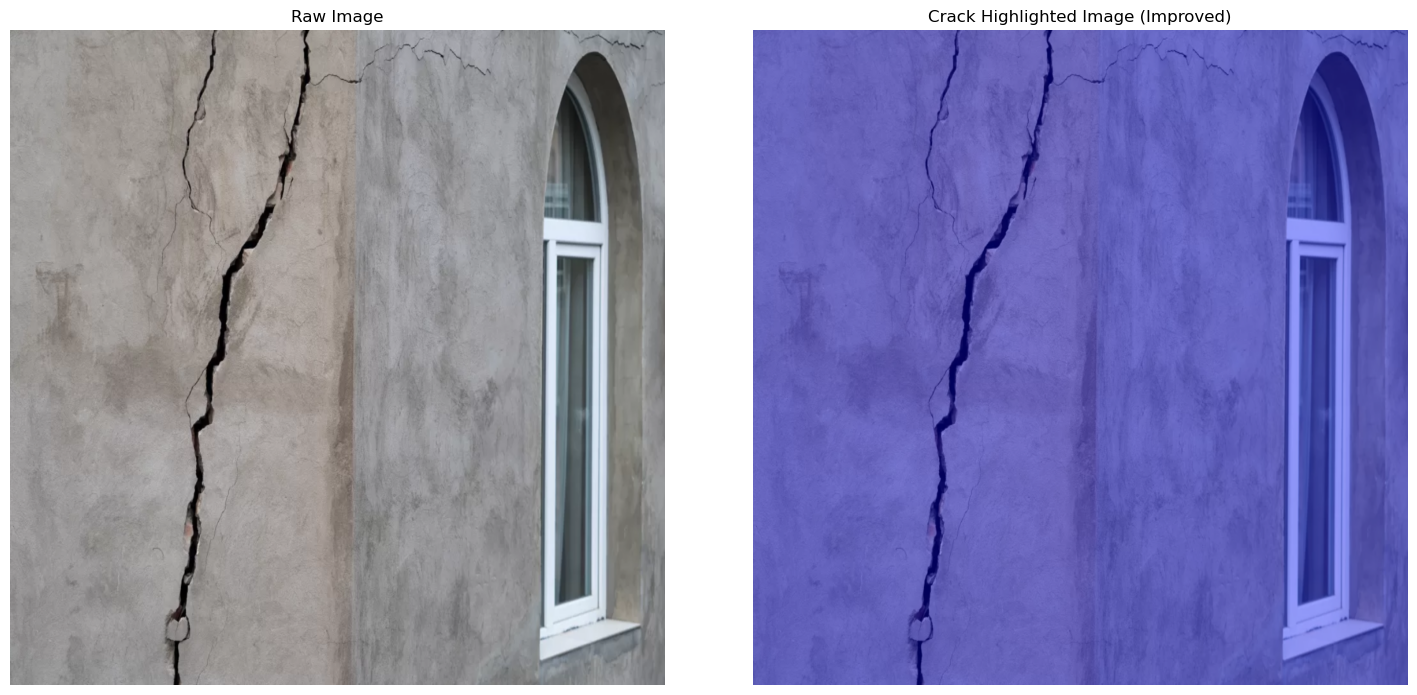

In [41]:
def highlight_cracks_improved(im, model):

    output_image = np.zeros_like(im)
    patch_size = 100
    overlap = 50  # Introduce overlap for better detection at patch boundaries
    highlight_color = (255, 0, 0)  # Red color for highlighting
    alpha_crack = 0.35  # Increased alpha for more visible cracks
    alpha_original = 0.65

    for y in range(0, im.shape[0] - patch_size + 1, patch_size - overlap):
        for x in range(0, im.shape[1] - patch_size + 1, patch_size - overlap):
            # Extract the patch
            patch = im[y:y + patch_size, x:x + patch_size]

            # Resize the patch to the model's input size
            resizeIm = cv2.resize(patch, (227, 227))
            im_arr = np.expand_dims(resizeIm, axis=0)

            # Predict using the model
            pred = model.predict(im_arr)
            prediction = np.array(pred).round()

            # If a crack is detected, highlight the original patch in the output image
            if prediction == 0:  # Assuming 0 represents a crack
                # Create a colored overlay for the crack
                overlay = np.zeros_like(patch, dtype=np.uint8)
                overlay[:] = highlight_color

                # Blend the overlay with the original patch
                blended_patch = cv2.addWeighted(patch, alpha_original, overlay, alpha_crack, 0)
                output_image[y:y + patch_size, x:x + patch_size] = blended_patch
            else:
                # If no crack, just copy the original patch
                output_image[y:y + patch_size, x:x + patch_size] = patch

    return output_image

# Load the image
random_image_path = "C:/Users/USER/Desktop/CRACK_DETECTION/istockphoto-1080117220-612x612.jpg"
im = cv2.imread(random_image_path)
if im is None:
    print(f"Error: Could not read image from {random_image_path}")
    exit()
im = cv2.resize(im, (1200, 1200))

# Highlight cracks using the improved function
crack_highlighted_image = highlight_cracks_improved(im, resnetModel)

# Display the images
fig = plt.figure(figsize=(15, 7))  # Adjusted figure size for better viewing
axisarr = fig.add_subplot(1, 2, 1)
axisarr.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
axisarr.set_title('Raw Image')
axisarr.axis('off')

axisarr = fig.add_subplot(1, 2, 2)
axisarr.imshow(cv2.cvtColor(crack_highlighted_image, cv2.COLOR_BGR2RGB))
axisarr.set_title('Crack Highlighted Image (Improved)')
axisarr.axis('off')

plt.tight_layout()
plt.show()

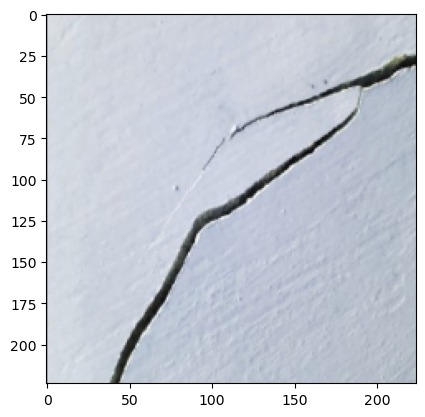

In [45]:
import cv2
import numpy as np
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# Load the image
random_image_path = "C:/Users/USER/Desktop/CRACK_DETECTION/istockphoto-1080117220-612x612_2.jpg"
img = cv2.imread(random_image_path)

# Resize the image to 224x224, which is the required input size for ResNet50
img_resized = cv2.resize(img, (224, 224))

# Convert the image to RGB (ResNet50 expects RGB images, OpenCV reads as BGR)
img_resized_rgb = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)

# Convert to a batch of images (ResNet50 expects a batch, not just a single image)
img_resized_rgb = np.expand_dims(img_resized_rgb, axis=0)

# Preprocess the image for ResNet50 (scales the image as per ResNet50 training)
img_preprocessed = preprocess_input(img_resized_rgb)

# At this point, img_preprocessed is ready to be passed into the ResNet50 model

# If you want to see the image
plt.imshow(img_resized_rgb[0])
plt.show()


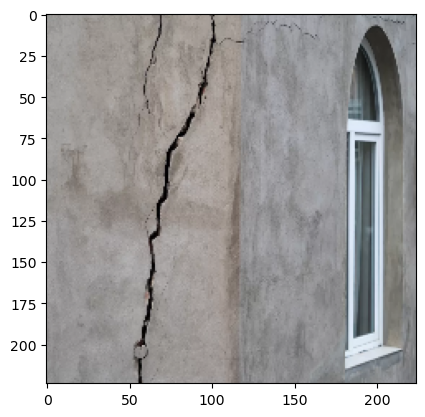

In [46]:
import cv2
import numpy as np
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# Load the image
random_image_path = "C:/Users/USER/Desktop/CRACK_DETECTION/istockphoto-1080117220-612x612.jpg"
img = cv2.imread(random_image_path)

# Resize the image to 224x224, which is the required input size for ResNet50
img_resized = cv2.resize(img, (224, 224))

# Convert the image to RGB (ResNet50 expects RGB images, OpenCV reads as BGR)
img_resized_rgb = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)

# Convert to a batch of images (ResNet50 expects a batch, not just a single image)
img_resized_rgb = np.expand_dims(img_resized_rgb, axis=0)

# Preprocess the image for ResNet50 (scales the image as per ResNet50 training)
img_preprocessed = preprocess_input(img_resized_rgb)

# At this point, img_preprocessed is ready to be passed into the ResNet50 model

# If you want to see the image
plt.imshow(img_resized_rgb[0])
plt.show()
